In [1]:
# Importing all needed libaries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual,HBox, Label
import ipywidgets as widgets
from scipy.integrate import odeint as ode
import matplotlib.pyplot as plt
import numpy as np
import math
from sympy import symbols, solve, simplify, sqrt
from sig import sig

In [2]:
"""
Variables
"""
g = 32.174 #ft/s^2

W_max = 1030500 # lb
rho_sl = 0.002377693 #slug/ft^3
K = 0.055579171
C_L_max = 5 #2.7198
h_obstacle = 50 #ft
T_max = 388000 # take off thrust
T_cont = 332400 # maximum cont. thrust
mu = 0.05 #rolling resistance
C_fe = 0.0035
C_D0 = 0.0176
S_ref = 5352 #ft^2
S_flap = 1256 #ft^2 area of flaps
S_tot = S_ref + S_flap
rho_cruise = 0.000891 #slug/ft^3 -> 30,000 ft
C = 2.805*2.20462 # lb/s -> thrust specific fuel consumption
cruise_alt = 30000 #ft
mach_max = 0.75 # maximum mach number
cruise_c = 990 #speed of sound at cruise
V_min = 370*1.68781 #ft/s
runway_dist = 5950 #ft -> max runway distance
n=1.2 
step_size=0.01
sf = 3 #significant figures

In [3]:
"""
Functions
"""

def stall_vel(W, S,rho, C_L):
    return np.sqrt( (2*W) / (rho*S*C_L) )

def Lift(rho, V, C_L, S):
    return 1/2 * rho * C_L * S * V**2

def Drag(rho, V, S, C_D0, K, C_L):
    return 1/2*rho*V**2* S * (C_D0 + K*C_L**2)





### GROUND ROLL
def ground_accel(W, T, D, L, mu):
    return g / W * (T - D - mu*(W - L) )

def ground_dist(T, W, S, mu, rho, C_L, C_D0, K, V_I, V_F):
    
    K_T = (T / W) - mu
    K_A = (rho * ( mu*C_L - C_D0 - K*C_L**2 ) ) / ( 2 * ( W / S ) )
    
    log_factor = K_T + K_A*V_F**2
    
    
   
    return (1 / (2*g*K_A) )*np.log(log_factor / (K_T + K_A*V_I**2) ), K_T, K_A

# Transition
def Gamma(T, D, W):
    return np.arcsin( (T - D) / W )



### Steady, Level Flight. Cruise.

# Eq 17.10 Raymer
# Use this to determine optimal Cruise altitude
def cruise_vel(rho, C_L, W, S):
    return np.sqrt( (2 * W) / (rho*C_L * S))

def thrust_to_weight(q, C_D0, W, S, K):
    return q*C_D0 / (W / S) + (W / S) * (K / q)

def W_dot(C, T):
    return -C*T


## Fuel Required:
# C * T at the different stages of flight.
# make sure range requirement is met.




In [4]:
def Take_Off(T, W, S, mu, rho, C_L, C_D0, K, n=1.2):
    
    V_stall = stall_vel(W, S, rho, C_L)
    V_to = 1.1*V_stall
    V_trans = 1.15*V_stall
    D_to = Drag(rho_sl, V_to, S, C_D0, K, C_L)
    
    S_G, K_T, K_A = ground_dist(T, W, S, mu, rho, C_L, C_D0, K, 0, V_to)
    S_R = 3*V_to
    
    R_trans = V_trans**2 / (g * (n - 1))

    gamma_climb = Gamma(T, D_to, W)

    h_TR = R_trans*(1 - np.cos(gamma_climb))

    if h_TR > h_obstacle:
        S_TR = np.sqrt(R_trans**2 - (R_trans - h_obstacle)**2)
    else:
        S_TR = R_trans*np.sin(gamma_climb)

    
   
        
    takeoff_distance = S_G + S_R + S_TR
    
    return takeoff_distance, S_G, S_R, S_TR, h_TR, gamma_climb, V_stall, V_to, V_trans, K_T, K_A




def Take_Off_Interact(engine_num, W, S, mu):
    
    T = T_max *engine_num/4
        
    TW = T/W #thrust to weight ratio
    b_coeff = -mu +(1/1.1**2)*(mu - TW)
    root_factor = np.sqrt((b_coeff)**2 - 4*K*C_D0)
    
    C_L_max = 1/(2*K) * (-b_coeff + root_factor)
    C_L_min = 1/(2*K) * (-b_coeff - root_factor)
    
    # Reduce bounds on graph
    if C_L_min < 0.5:
        C_L_min = 0.5
    
    C_L_array = np.arange(C_L_min, C_L_max-0.05, step_size)
    
    dist_tot_array = np.zeros_like(C_L_array)
    S_G_array = np.zeros_like(C_L_array)
    S_TR_array = np.zeros_like(C_L_array)
    S_R_array = np.zeros_like(C_L_array)
    h_TR_array = np.zeros_like(C_L_array)
    gamma_array = np.zeros_like(C_L_array)
    
    for i in range(len(C_L_array)):
        dist_tot_array[i] = Take_Off(T, W, S, mu, rho_sl, C_L_array[i], C_D0, K)[0]
        S_G_array[i] = Take_Off(T, W, S, mu, rho_sl, C_L_array[i], C_D0, K)[1]
        S_TR_array[i] = Take_Off(T, W, S, mu, rho_sl, C_L_array[i], C_D0, K)[3]
        S_R_array[i] = Take_Off(T, W, S, mu, rho_sl, C_L_array[i], C_D0, K)[2]
        h_TR_array[i] = Take_Off(T, W, S, mu, rho_sl, C_L_array[i], C_D0, K)[4]
        gamma_array[i] = Take_Off(T, W, S, mu, rho_sl, C_L_array[i], C_D0, K)[5]

    
    min_dist = np.min(dist_tot_array)
    min_dist_index = np.where(dist_tot_array == min_dist)[0][0]
    C_L_min_dist = C_L_array[min_dist_index]
    min_h_TR = h_TR_array[min_dist_index]
    min_gamma = np.degrees(gamma_array[min_dist_index])
    
    min_clearance = min_h_TR - h_obstacle
    
    
    if min_dist > runway_dist:
        print('FAILED: Runway not cleared.')
    else:
        print('SUCCESS: Runway cleared.')
        min_C_L_for_takeoff = C_L_array[np.where(dist_tot_array < runway_dist)[0][0]]
        print('C_L for take-off distance of exactly ', runway_dist, 'ft = ',sig(min_C_L_for_takeoff, sf))
    
    print('Minimum take-off distance = ',sig(min_dist,sf), ' ft')
    print('C_L for minimum take-off = ',sig(C_L_min_dist,sf))
    print('Clearance of 50 ft Obstacle at minimum take-off = ',sig(min_h_TR,sf), ' ft')
    print('Transition Climb Angle = ',sig(min_gamma,sf), ' deg')
   
    
    plt.figure(figsize=(8,7))
    plt.plot(C_L_array, dist_tot_array, label='Total Distance')
    plt.plot(C_L_array, S_G_array, label='Ground Roll', color='b')
    plt.plot(C_L_array, S_TR_array, label='Transition Distance', color='purple')
    plt.plot(C_L_array, S_R_array, label='Rotation Ground Roll Distance',color='black')
    plt.xlabel('$C_L (-)$')
    plt.ylabel('Take-off Distance (ft)')
    plt.grid()
    plt.legend()
    plt.axhline(y=5950,color='r',linestyle='--')
    plt.annotate('5950 ft',[0.5, 6100])
    plt.plot(C_L_min_dist, min_dist, marker='x', color='black',markersize=20)
    if min_dist < runway_dist:
        plt.plot(min_C_L_for_takeoff, runway_dist, marker='x', color='black',markersize=20)
    
    """
    plt.figure(figsize=(8,7))
    plt.plot(C_L_array, Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[7], color='r')
    plt.xlabel('$C_L$ (-)')
    plt.ylabel('Take-Off Velocity (ft/sec)')
    plt.grid()
    
    plt.figure(figsize=(7,6))
    plt.plot(C_L_array, np.degrees(Take_Off(T, W, S, mu, rho_sl, C_L_array, C_D0, K)[5]), color='r')
    plt.xlabel('$C_L$ (-)')
    plt.ylabel('Climb Angle (deg)')
    plt.grid()
    """

    return None


max V:  439.91918521634545
max range:  0.16730415055740314 nmi / lb
velocity for max range:  6991.3496859817515 kts
Fuel Required:  34428.31502272687  lb
Lift Array:  [1021620.2733436  1021652.99164443 1021685.71046918 ... 1444089.807861
 1444128.70722842 1444167.60711975]
Drag Array:  [65433.01809539 65435.11364618 65437.20923052 ... 92491.46379983
 92493.95523728 92496.44670829]
1030500
332400
2.0459727777777776


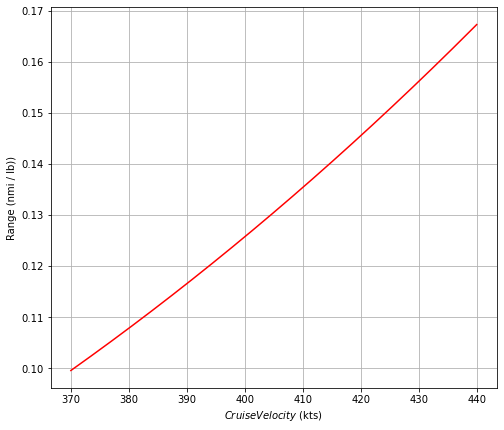

In [5]:
# Equation 17.3 Raymer
def Endurance(L, D, C, W_i, W_f):
    return (L / D) * (1 / C) * np.log(W_i / W_f)


# C = lb/s
# V = ft/s
# V/C = ft/lb
# Equation  17.23, Raymer
def Range(L, D, C, W_i, W_f, V):
    return Endurance(L,D,C,W_i,W_f) * V


### best range equations
def Range_Parameters(W, S):
    
    V = np.sqrt((2*W)/(rho_cruise*S) * np.sqrt(3*K / C_D0))
    D = 1/2 * rho_cruise * V**2 * S * (4/3 * C_D0)
    C_L = np.sqrt(C_D0 / (3*K))
    
    return V, D, C_L


# M = V/C, -> V = M*C
V_max = cruise_c * mach_max


range_req = 4800 # nmi

print('max V: ',V_max / 1.68781)


def Range_Interact(W_max, C_L, S, T):
    """
    W_max = maximum weight
    V = cruise velocity
    C_L = coefficient of lift at zero AoA
    S = wing span (no flaps)
    T = thrust
    """
    
    W_i = W_max
    W_f = W_max*0.6


    
    
    V_array = np.arange(V_min+step_size, V_max, step_size)
    range_array = np.zeros_like(V_array)
    L_array = np.zeros_like(V_array)
    D_array = np.zeros_like(V_array)
    
    for i in range(len(V_array)):
        L_array[i] = Lift(rho_cruise, V_array[i], C_L, S)
        D_array[i] = Drag(rho_cruise, V_array[i], S, C_D0, K, C_L)
        range_array[i] = Range(L_array[i], T, C, W_i, W_f, V_array[i])

    
    max_range = np.max(range_array)
    V_max_range = np.where(range_array == max_range)[0][0]
    
    
    
    min_fuel = 1.2 * range_req / (max_range*0.000164579) 
    
    
        
    plt.figure(figsize=(8,7))
    plt.plot(V_array /1.68781, range_array*0.000164579, color='r')
    plt.xlabel('$Cruise Velocity $ (kts)')
    plt.ylabel('Range (nmi / lb))')
    plt.grid()
    
    print('max range: ',max_range*0.000164579, 'nmi / lb')
    print('velocity for max range: ',V_max_range / 1.6878, 'kts')
    print('Fuel Required: ',min_fuel, ' lb')
    
    print('Lift Array: ',L_array)
    print('Drag Array: ',D_array)
    
    return range_array, max_range, V_max_range

C_L = 0.7
Range_Interact(W_max, C_L, 8400, 87134)
print(W_max)
print(T_cont)

CC = 0.478*(61636/4) / 3600
print(CC)

In [6]:
### Loiter Endurance

# Optimal velocity, is the velocity that minimises thrust/drag.

def loiter_vel(W, S, rho):
    return np.sqrt((2*W)/(rho*S)*np.sqrt(K/C_D0) )

V_loiter = loiter_vel(W_max*0.7, S_ref, 17.56e-4)

def min_drag(V, S):
    return C_D0 * rho_cruise * V**2

V_cruise_min = stall_vel(W_max*0.7, S_ref,17.56e-4, 0.7)
D_min = min_drag(V_loiter, S_ref)

print(V_loiter / 1.6878)
print(D_min)
print(V_cruise_min / 1.6878)

309.45433749847916
4.277849345029282
277.4582898868206


In [7]:
## Climb Optimisation


def climb_angle(T, D, W):
    return np.arcsin((T - D) / W)



def climb_vel(W, S, T, rho):
    TW = T / W #thrust to weight ratio
    
    return np.sqrt( W / (S*3*rho*C_D0) * (TW + np.sqrt(TW)**2 + 12*C_D0*K) )

V_climb = climb_vel(W_max*0.95, S_ref, T_cont, rho_sl) / 1.6878
print(V_climb)

# V[i+1] = V_climb(W, S, T, rho[i]+V_climb*step_size)

h_TR = 1000 #ft - height at end of transition

vert_dist = cruise_alt - h_TR

rho_5k = 20.48e-4
rho_10k = 17.56e-4
rho_15k = 14.96e-4
rho_20k = 12.67e-4
rho_25k = 10.66e-4

rho_array = np.array([rho_sl, rho_5k, rho_10k, rho_15k, rho_20k, rho_25k, rho_cruise])
climb_array = np.zeros_like(rho_array)
for i in range(len(rho_array)):
    climb_array[i] = climb_vel(W_max*0.95, S_ref, T_cont, rho_array[i])
    

print(step_size)
print(vert_dist)

print(V_climb*step_size)
print(climb_array / 1.6878)

gamma = climb_angle(T_cont, D_min, W_max*0.99)
print(np.degrees(gamma))

594.4195519184652
0.01
29000
5.944195519184652
[594.41955192 640.48062927 691.6855769  749.38531579 814.29668758
 887.75345924 971.02882824]
19.015011584896435


In [8]:
style = {'description_width': 'initial'}
interact_manual(Take_Off_Interact,
                engine_num=widgets.IntSlider(min=1, max=4,step=1,value=4, description= 'Engine Number',style=style),
                W=widgets.FloatSlider(min=500000, max=1500000, step =100, value=W_max, description ='Take-Off Weight (lb)',style=style),
                S=widgets.FloatSlider(min=1000, max=15000, step =10, value=S_tot, description ='Wing Area ($ft^2$)',style=style),
                mu=widgets.FloatSlider(min=0.02, max=0.05, step =0.01, value=0.02, description ='Coefficient of Friction ($\mu$)',style=style),
               )

interactive(children=(IntSlider(value=4, description='Engine Number', max=4, min=1, style=SliderStyle(descript…

<function __main__.Take_Off_Interact(engine_num, W, S, mu)>

In [9]:
### LANDING

# W = 0.85*W_to

# V_a = 1.2*V_stall

# angle must be less than 3 degrees.

#V_a = 1.2 * stall_vel(W, S,rho, C_L)

#gamma = Gamma(T, D, W)



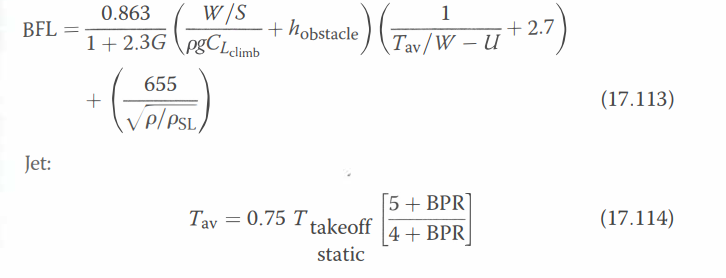


In [10]:
# Balanced Field Length

BPR = 9.61 # for trent XWB
gamma_min = 0.030
def Balanced_Field_Length(C_L, W, S, T, BPR, V):
    
    
    T_av = 0.75*T*(5+BPR)/(4+BPR)
    V_stall = stall_vel(W, S,rho_sl, C_L)
    D = Drag(rho_sl, V, S, C_D0, K, C_L)
    gamma_climb = Gamma(T_av, D, W)
    U = 0.01*C_L + 0.02
    G = gamma_climb - gamma_min
    
    BFL = (0.863 / (1 + 2.3*G))*((W/S)/(rho_sl*g*C_L) + h_obstacle)*(1/(T_av/W - U) + 2.7) + (655) # assume rho = rho_sl
    
    return BFL, T_av, gamma
S_ref = 6730
V = stall_vel(W_max, S_ref,rho_sl, 3)*1.2
BPR, T_av, climb = Balanced_Field_Length(3, W_max, S_ref, T_max, BPR, V)

print(BPR)
print(T_av / T_max)
print(np.degrees(climb))

4550.675611970544
0.8051065393093314
19.015011584896435


max range:  0.07529434310604446 nmi / lb
velocity for max range:  6991.3496859817515 kts
Fuel Required:  76499.7709308337  lb
Lift Array:  [1753955.21418429 1754011.38616506 1754067.5590453  ... 2479266.43033279
 2479333.21419573 2479399.99895814]
Drag Array:  [166804.806343   166810.14841576 166815.49057406 ... 235783.41877828
 235789.77006321 235796.12143368]
-----------------------------------------------------------------------------------
((4854.626617595639, 3264.9988192547294, 670.2340213380444, 919.3937770028656, 103.74278551934893, 0.15660115945443465, 203.10121858728616, 223.41134044601478, 233.56640137537906, 0.3265162542455119, -3.2066913527074564e-06),)


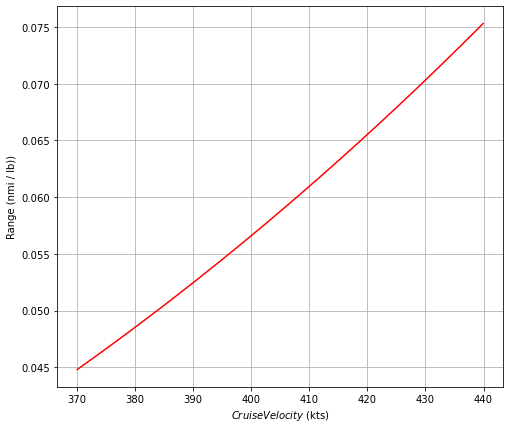

In [11]:
## calculations

C_L_max = 3.18


def Mission(T_max, W, S, mu, rho, C_L, C_D0, K):
    takeoff_distance, S_G, S_R, S_TR, h_TR, gamma_climb, V_stall_takeoff, V_to, V_trans, \
    K_T, K_A = Take_Off(T_max, W, S, mu, rho, C_L, C_D0, K)
    
    _, range_max, v_range_max = Range_Interact(W, 1.5, S_ref, T_cont)
    
    print("-----------------------------------------------------------------------------------")
    
    return (takeoff_distance, S_G, S_R, S_TR, h_TR, gamma_climb, V_stall_takeoff, V_to, V_trans, K_T, K_A), 
    (range_max, v_range_max)

test = Mission(T_max, W_max, S_tot, mu, rho_sl, C_L_max, C_D0, K)

print(test)
